# Regrid FESOM to Regular Grid

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd 

import sys
sys.path.append("../")

import pyfesom as pf
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib import cm 
from netCDF4 import Dataset

import glob

import cmocean as cmo
import cftime

from IPython import display
from tqdm import tqdm

sys.path.append("/albedo/home/quraus001/FESOM-FS-subduction/functions/")
import FESOM_processing as fprc
import FESOM_plotting as fplt

import xesmf as xe
print(xe.__version__)

/albedo/home/quraus001/pyfesom/pyfesom/climatology.py:21: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


0.8.10


In [2]:
meshpath = "/albedo/home/quraus001/Arc08_sub/"
datapath = "/albedo/work/projects/oce_rio/cwekerle/result/Arc40/from_1988_erai/"
plotpath = "/albedo/home/quraus001/FESOM-FS-subduction/plots/"

In [3]:
mesh   = pf.load_mesh(meshpath)
ds_oce = fprc.load_FESOM_data_with_grid(meshpath, datapath + "Arc40.2002.oce.mean.sub.nc", vars="oce")

file = "/albedo/work/projects/oce_rio/cwekerle/result/Arc22_sub_daily/gridded_python/Arc22.gridded_100m_oce_2006_2009_new.nc"
ds_gridded = xr.open_dataset(file)
ds_gridded = ds_gridded.rename({'longitude': 'lon', 'latitude': 'lat'})

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3


In [ ]:
ds_oce

## Create Land-Sea Mask for New Grid

In [ ]:
# Load Bathymetry data
ds_bath = xr.open_dataset("/albedo/work/user/quraus001/bath/ETOPO_2022_v1_60s_N90W180_bed.nc")

# Crop to Fram Strait region
ds_fram_bath = ds_bath.sel(
    lon=slice(-35, 35),    
    lat=slice(70, 85)).copy()
ds_fram_bath = ds_fram_bath.rename({'lon': 'lon', 'lat': 'lat'})

# Create a new grid
grid_out = xr.Dataset({
    'lon': (['lon'], ds_gridded.lon.values),
    'lat': (['lat'], ds_gridded.lat.values),
})

# Regridder
regridder = xe.Regridder(ds_fram_bath, grid_out, method='bilinear', periodic=False)
z_interp = regridder(ds_fram_bath['z'])
# Create a mask for land points
lsmask = z_interp > 0
# add names to the mask
lsmask = lsmask.rename('lsmask')
lsmask.to_netcdf("FESOM-FS-lsmask_regridded_lat825-lon800.nc")

: 

## Loading LS Mask

In [4]:
ds_lsmask = xr.open_dataset("/albedo/home/quraus001/FESOM-FS-subduction/outdata/FESOM-FS-lsmask_regridded_lat825-lon800.nc")
ds_lsmask = ds_lsmask.rename({'__xarray_dataarray_variable__': 'lsmask'})
lsmask = ds_lsmask.lsmask
ds_lsmask

<xarray.Dataset> Size: 673kB
Dimensions:  (lon: 800, lat: 825)
Coordinates:
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
Data variables:
    lsmask   (lat, lon) bool 660kB ...

## Regridding one depth level

In [15]:
depth_level = 0
variables = ["u", "v", "temp", "salt"]

# Grid
lon_new = np.linspace(ds_gridded.lon.min().item(), ds_gridded.lon.max().item(), len(ds_gridded.lon))
lat_new = np.linspace(ds_gridded.lat.min().item(), ds_gridded.lat.max().item(), len(ds_gridded.lat))
lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)

# Create dataset for gridded data
ds_gridded = xr.Dataset(
    {
        "temp": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "salt": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "u": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
        "v": (["time", "lat", "lon"], np.zeros((len(ds_oce.time), len(lat_new), len(lon_new)))),
    },
    coords={
        "time": ds_oce.time.values,
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    },
)

for variable in variables:
    print(variable)
    for idx, time in tqdm(enumerate(ds_oce.time.values[:])):
        # Get the data for the current time step
        raw_data     = fprc.reshape_3d_nodes(ds_oce, variable, time_idx=idx)
        # Interpolate the data to the new grid
        gridded_data = pf.fesom2regular(raw_data[:,depth_level], mesh, lon_mesh, lat_mesh , how='nn')
        # Apply the mask to the gridded data
        gridded_data[lsmask] = np.nan  # Set land points to NaN
        # Store the gridded data in the dataset
        ds_gridded[variable].loc[dict(time=time)] = gridded_data

# Save the gridded dataset to a NetCDF file
output_file = "/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_new.nc"
ds_gridded.to_netcdf(output_file, mode='w', format='NETCDF4')
ds_gridded

u


365it [24:18,  4.00s/it]


v


365it [23:59,  3.94s/it]


temp


365it [23:53,  3.93s/it]


salt


365it [23:50,  3.92s/it]


<xarray.Dataset> Size: 8GB
Dimensions:  (time: 365, lat: 825, lon: 800)
Coordinates:
  * time     (time) object 3kB 2002-01-01 23:57:30 ... 2002-12-31 23:57:30
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
Data variables:
    temp     (time, lat, lon) float64 2GB nan -1.731 -1.731 ... -1.841 -1.841
    salt     (time, lat, lon) float64 2GB nan 31.71 31.71 ... 33.61 33.6 33.6
    u        (time, lat, lon) float64 2GB nan 0.01576 ... 0.01552 0.01552
    v        (time, lat, lon) float64 2GB nan 0.00879 ... -0.00428 -0.00428

## Regridding 3D

In [6]:
variables = ["u", "v", "w", "temp"]#, "salt"]
time_steps = 2
times = ds_oce.time.values[:time_steps]
depth_cut_off = 2  # Exclude the last two depth levels (NaNs)

# Rot

# Grid
lon_new = np.linspace(ds_gridded.lon.min().item(), ds_gridded.lon.max().item(), len(ds_gridded.lon))
lat_new = np.linspace(ds_gridded.lat.min().item(), ds_gridded.lat.max().item(), len(ds_gridded.lat))
lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)

# Create dataset for gridded data
ds_gridded = xr.Dataset(
    {
        "temp": (["time", "z","lat", "lon"], np.zeros((len(times), len(ds_oce.depth_levels)-depth_cut_off, len(lat_new), len(lon_new)))),
        "salt": (["time", "z","lat", "lon"], np.zeros((len(times), len(ds_oce.depth_levels)-depth_cut_off, len(lat_new), len(lon_new)))),
        "u": (["time", "z","lat", "lon"], np.zeros((len(times), len(ds_oce.depth_levels)-depth_cut_off, len(lat_new), len(lon_new)))),
        "v": (["time", "z","lat", "lon"], np.zeros((len(times), len(ds_oce.depth_levels)-depth_cut_off, len(lat_new), len(lon_new)))),
        "w": (["time", "z","lat", "lon"], np.zeros((len(times), len(ds_oce.depth_levels)-depth_cut_off, len(lat_new), len(lon_new)))),
    },
    coords={
        "time": times,
        "z": ds_oce.depth_levels.values[:-depth_cut_off],  # Exclude the last two levels (NaNs)
        "lat": (["lat"], lat_new),
        "lon": (["lon"], lon_new),
    },
)

ds_gridded['z'] = -ds_gridded['z']  # make depth positive
ds_gridded['z'] = abs(ds_gridded['z'].values)

ds_gridded

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 2, z: 45, lat: 825, lon: 800)
Coordinates:
  * time     (time) object 16B 2002-01-01 23:57:30 2002-01-02 23:57:30
  * z        (z) float64 360B 0.0 10.0 20.0 30.0 ... 5.15e+03 5.4e+03 5.65e+03
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
Data variables:
    temp     (time, z, lat, lon) float64 475MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    salt     (time, z, lat, lon) float64 475MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u        (time, z, lat, lon) float64 475MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v        (time, z, lat, lon) float64 475MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    w        (time, z, lat, lon) float64 475MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

Replace NaNs with -100


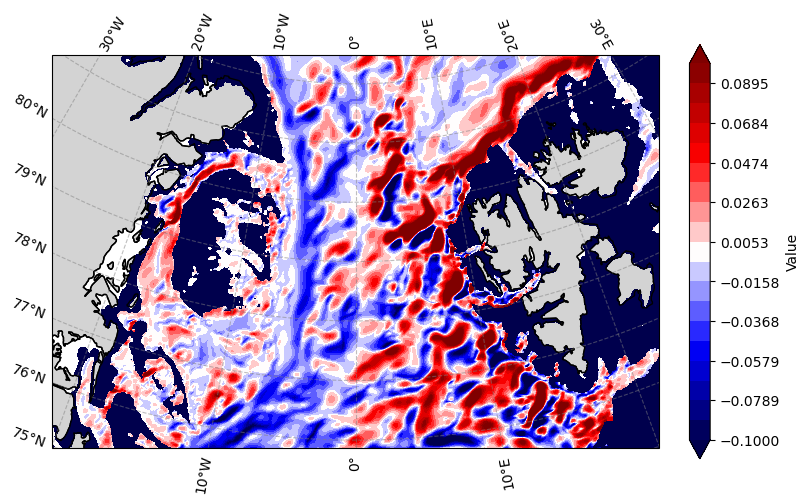

In [5]:
ds_oce_rotated = rotate_fesom_velocities(ds_oce.isel(time=0), mesh)
raw_data = fprc.reshape_3d_nodes(ds_oce_rotated, "u_east", time_idx=0)
plot_polar_contourf = fplt.plot_polar_contourf(mesh, raw_data[:,15], levels=np.linspace(-0.1,0.1, 20), cmap="seismic")

In [ ]:
glob.glob("/albedo/scratch/user/fheukamp/PostDoc1/FramStrait/FESOM1km_Claudia_transformed/gridded/w.fesom.2001.30*nc")

['/albedo/scratch/user/fheukamp/PostDoc1/FramStrait/FESOM1km_Claudia_transformed/gridded/w.fesom.2002.01.15.nc',
 '/albedo/scratch/user/fheukamp/PostDoc1/FramStrait/FESOM1km_Claudia_transformed/gridded/w.fesom.2002.01.11.nc',
 '/albedo/scratch/user/fheukamp/PostDoc1/FramStrait/FESOM1km_Claudia_transformed/gridded/w.fesom.2002.01.08.nc',
 '/albedo/scratch/user/fheukamp/PostDoc1/FramStrait/FESOM1km_Claudia_transformed/gridded/w.fesom.2002.01.30.nc',
 '/albedo/scratch/user/fheukamp/PostDoc1/FramStrait/FESOM1km_Claudia_transformed/gridded/w.fesom.2002.01.25.nc']

In [19]:
ds_finn = xr.open_dataset("/albedo/scratch/user/fheukamp/PostDoc1/FramStrait/FESOM1km_Claudia_transformed/gridded/w.fesom.2001.12.30.nc")

In [27]:
ds_finn

<xarray.Dataset> Size: 333MB
Dimensions:  (lat: 1100, lon: 840, depth: 45)
Coordinates:
  * lon      (lon) float64 7kB -20.0 -19.95 -19.9 -19.86 ... 19.9 19.95 20.0
  * lat      (lat) float64 9kB 75.0 75.01 75.02 75.03 ... 84.97 84.98 84.99 85.0
  * depth    (depth) float64 360B 0.0 -10.0 -20.0 ... -5.4e+03 -5.65e+03
Data variables:
    w        (lat, lon, depth) float64 333MB ...

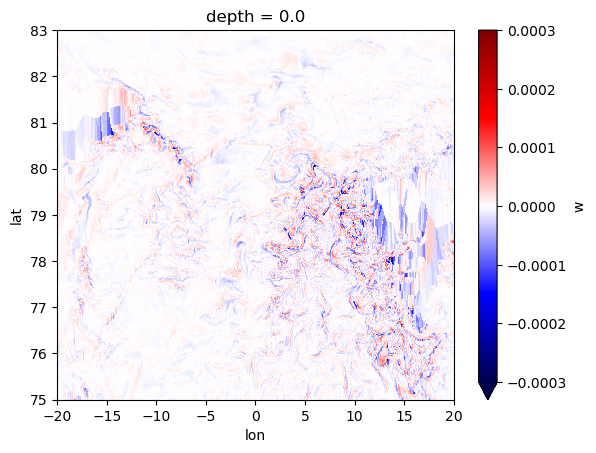

In [31]:
ds_finn.w.isel(depth=0).sel(lat=slice(75,83)).plot(cmap="seismic", vmin=-0.0003, vmax=0.0003)

In [24]:
np.linspace(-0.0003,0.0003, 20)

array([-3.00000000e-04, -2.68421053e-04, -2.36842105e-04, -2.05263158e-04,
       -1.73684211e-04, -1.42105263e-04, -1.10526316e-04, -7.89473684e-05,
       -4.73684211e-05, -1.57894737e-05,  1.57894737e-05,  4.73684211e-05,
        7.89473684e-05,  1.10526316e-04,  1.42105263e-04,  1.73684211e-04,
        2.05263158e-04,  2.36842105e-04,  2.68421053e-04,  3.00000000e-04])

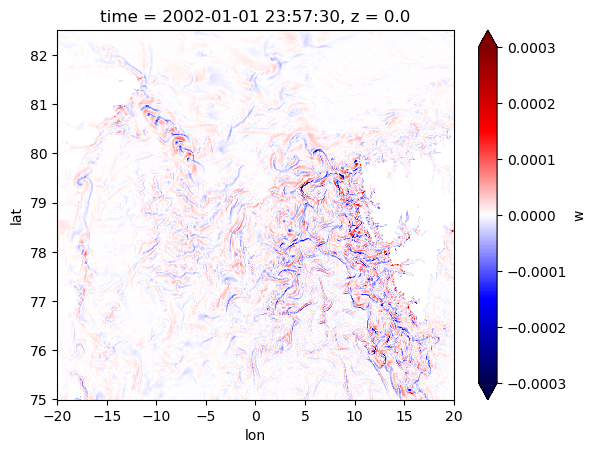

In [30]:
inpath = "/albedo/work/user/quraus001/processed_data/gridded/"

file = "Arc40.2002.oce.mean.sub_gridded_3d_T30.nc" 
ds_model = xr.open_dataset(inpath + file)
ds_model.w.isel(time=0, z=0).plot(cmap="seismic", vmin=-0.0003, vmax=0.0003)

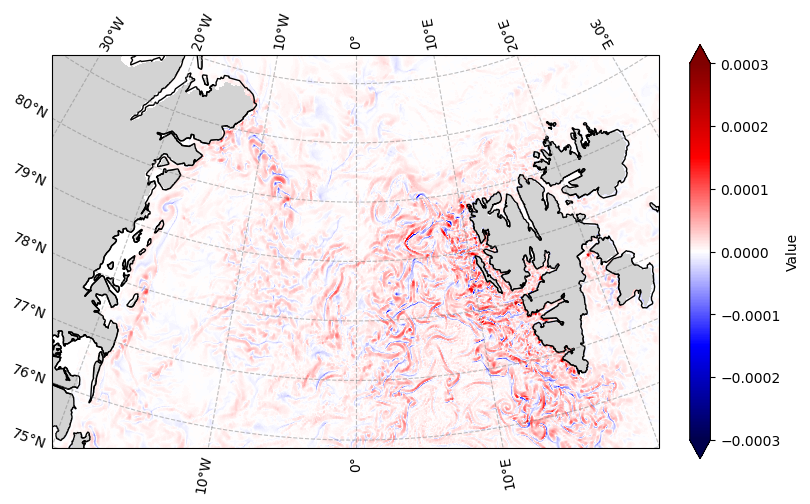

In [35]:
raw_data = fprc.reshape_3d_nodes(ds_oce, "w", time_idx=0)
fig, ax = fplt.plot_polar_contourf(mesh, raw_data[:,0], levels=np.arange(-0.0003,0.0003+0.0000005, 0.0000005), cmap="seismic", show=False)
# get current colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.arange(-0.0003, 0.0003+0.0001, 0.0001))

Replace NaNs with -100


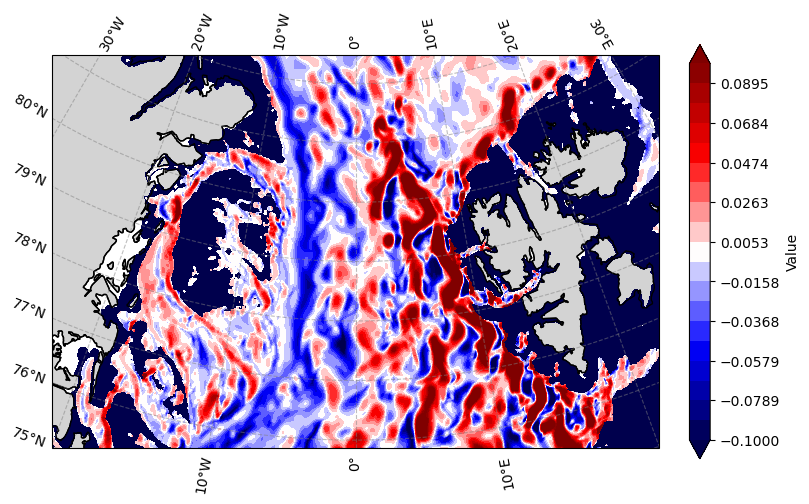

In [7]:
raw_data = fprc.reshape_3d_nodes(ds_oce, "u", time_idx=0)
plot_polar_contourf = fplt.plot_polar_contourf(mesh, raw_data[:,15], levels=np.linspace(-0.1,0.1, 20), cmap="seismic")

In [9]:
for variable in variables[:]:
    print(variable)
    for idx, time in tqdm(enumerate(times)):
        # rotate the velocities for the current time step
        ds_oce_rotated = fprc.rotate_fesom_velocities_const_alpha(ds_oce.isel(time=idx), mesh) 
        # Get the data for the current time step and transform 3d nodes to 2d x depth
        raw_data = fprc.reshape_3d_nodes(ds_oce_rotated, variable, time_idx=idx)

        for depth_level in range(raw_data.shape[1]-depth_cut_off):
            # Interpolate the data to the new grid
            gridded_data = pf.fesom2regular(raw_data[:,depth_level], mesh, lon_mesh, lat_mesh , how='nn')
            # Apply the mask to the gridded data
            gridded_data[lsmask] = np.nan  # Set land points to NaN
            # Store the gridded data in the dataset
            ds_gridded[variable].loc[dict(time=time)].values[depth_level,:,:] = gridded_data

# Save the gridded dataset to a NetCDF file
output_file = f"/albedo/work/user/quraus001/processed_data/gridded/Arc40.2002.oce.mean.sub_gridded_3d_T{time_steps}.nc"
ds_gridded.to_netcdf(output_file, mode='w', format='NETCDF4')
ds_gridded

u


2it [04:06, 123.08s/it]


v


2it [03:39, 109.83s/it]


w


2it [03:17, 98.78s/it] 


temp


2it [03:16, 98.08s/it]


<xarray.Dataset> Size: 2GB
Dimensions:  (time: 2, z: 45, lat: 825, lon: 800)
Coordinates:
  * time     (time) object 16B 2002-01-01 23:57:30 2002-01-02 23:57:30
  * z        (z) float64 360B 0.0 10.0 20.0 30.0 ... 5.15e+03 5.4e+03 5.65e+03
  * lat      (lat) float64 7kB 75.0 75.01 75.02 75.03 ... 82.47 82.48 82.49 82.5
  * lon      (lon) float64 6kB -20.0 -19.95 -19.9 -19.85 ... 19.9 19.95 20.0
Data variables:
    temp     (time, z, lat, lon) float64 475MB nan -1.731 -1.731 ... nan nan nan
    salt     (time, z, lat, lon) float64 475MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u        (time, z, lat, lon) float64 475MB nan 0.003396 0.003396 ... nan nan
    v        (time, z, lat, lon) float64 475MB nan 0.01772 0.01772 ... nan nan
    w        (time, z, lat, lon) float64 475MB nan 1.835e-06 ... nan nan

In [8]:
def rotate_fesom_velocities(ds_fesom: xr.Dataset, mesh) -> xr.Dataset:
    """
    Rotates FESOM's native 'u' and 'v' velocity components to true East-North
    components using a global rotation angle from the FESOM mesh.

    Parameters:
    -----------
    ds_fesom : xarray.Dataset
        The original FESOM dataset containing 'u' and 'v' variables
        with a 'nodes_3d' dimension.
    mesh : pyfesom.mesh
        The loaded FESOM mesh object, containing the global 'alpha'
        rotation angle.

    Returns:
    --------
    xarray.Dataset
        A new dataset with 'u_east' and 'v_north' variables added,
        and the original 'u' and 'v' variables dropped.
        The data remains on the original 'nodes_3d' unstructured grid.

    Raises:
    -------
    ValueError
        If 'u' or 'v' variables are missing from the input dataset.
        If 'mesh.alpha' is not found or is not a scalar (int or float).
    """

    if 'u' not in ds_fesom or 'v' not in ds_fesom:
        raise ValueError("Input dataset must contain 'u' and 'v' variables for rotation.")

    # --- Obtain Rotation Angles from mesh.alpha ---
    # mesh.alpha is confirmed to be a single scalar value (global rotation angle in degrees).
    
    if not hasattr(mesh, 'alpha') or not isinstance(mesh.alpha, (int, float)):
        raise ValueError(
            "The 'mesh' object does not have a suitable 'alpha' attribute or it's not a scalar (int/float). "
            "Please ensure your FESOM mesh setup and pyFESOM loading correctly provide this."
        )

    # Get the global alpha value
    global_alpha_deg = float(mesh.alpha) # Ensure it's a float for numpy operations
    
    # Create an array of this global angle, matching the size of nodes_3d
    # All 3D nodes will be rotated by the same global angle.
    num_nodes_3d = ds_fesom['nodes_3d'].size
    angle_deg_array = np.full(num_nodes_3d, global_alpha_deg)
            
    # Convert angle to radians
    angle_rad = np.deg2rad(angle_deg_array)
    
    # Ensure angle_rad is an xarray DataArray aligned with 'nodes_3d' for broadcasting
    angle_rad_da = xr.DataArray(angle_rad, coords={'nodes_3d': ds_fesom['nodes_3d']}, dims='nodes_3d')

    # --- Perform the Rotation ---
    u_fesom = ds_fesom['u']
    v_fesom = ds_fesom['v']

    # Standard 2D rotation matrix:
    # u_true_east = u_local * cos(angle) - v_local * sin(angle)
    # v_true_north = u_local * sin(angle) + v_local * cos(angle)
    u_true_east = u_fesom * np.cos(angle_rad_da) - v_fesom * np.sin(angle_rad_da)
    v_true_north = u_fesom * np.sin(angle_rad_da) + v_fesom * np.cos(angle_rad_da)

    # --- Create new dataset with rotated velocities ---
    ds_rotated = ds_fesom.copy(deep=True)

    ds_rotated['u_east'] = u_true_east
    ds_rotated['v_north'] = v_true_north

    # Drop original 'u' and 'v' to avoid confusion and save space
    ds_rotated = ds_rotated.drop_vars(['u', 'v'])

    # Rename u_east and v_north to match the original variable names
    ds_rotated = ds_rotated.rename({'u_east': 'u', 'v_north': 'v'})
    # ... but change attributes to indicate these are now rotated
    ds_rotated['u'].attrs['description'] = 'True Eastward velocity component (rotated from FESOM u)'
    ds_rotated['v'].attrs['description'] = 'True Northward velocity component (rotated from FESOM v)'

    return ds_rotated
